In [52]:
import os
import xarray as xr
import numpy as np
import datetime as dt
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from tqdm import tqdm_notebook as tqdm

In [53]:
DATA_DIR =  '/local/S.Rasp/ML-Workshop-Data/dataset2/'

In [54]:
!ls $DATA_DIR

forecast_errors.png  nwp_envca-gdps.nc		     sample_submission.csv
metobs.nc	     nwp_ncep-gfs4.nc		     solution.csv
ml_workshop_data.7z  power_curve_single_turbine.png  windpark.nc
nwp_ecmwf-ifs.nc     README.md			     windpark_train.nc


## Check out the data

### NWP data

In [55]:
nwp_ec = xr.open_dataset(DATA_DIR + 'nwp_ecmwf-ifs.nc')
nwp_en = xr.open_dataset(DATA_DIR + 'nwp_envca-gdps.nc')
nwp_nc = xr.open_dataset(DATA_DIR + 'nwp_ncep-gfs4.nc')

In [56]:
nwps = [nwp_ec, nwp_en, nwp_nc]
nwps

[<xarray.Dataset>
 Dimensions:   (epoch_s: 1463, offset_s: 49)
 Coordinates:
   * epoch_s   (epoch_s) int32 1420070400 1420113600 1420156800 1420200000 ...
   * offset_s  (offset_s) int32 0 10800 21600 32400 43200 54000 64800 75600 ...
 Data variables:
     ws100m    (epoch_s, offset_s) float32 ...
     wd100m    (epoch_s, offset_s) float32 ...
     ws10m     (epoch_s, offset_s) float32 ...
     wd10m     (epoch_s, offset_s) float32 ...
     t2m       (epoch_s, offset_s) float32 ...
     blh       (epoch_s, offset_s) float32 ..., <xarray.Dataset>
 Dimensions:   (epoch_s: 1463, offset_s: 49)
 Coordinates:
   * epoch_s   (epoch_s) int32 1420070400 1420113600 1420156800 1420200000 ...
   * offset_s  (offset_s) int32 0 10800 21600 32400 43200 54000 64800 75600 ...
 Data variables:
     ws1000mb  (epoch_s, offset_s) float32 ...
     wd1000mb  (epoch_s, offset_s) float32 ...
     ws925mb   (epoch_s, offset_s) float32 ...
     wd925mb   (epoch_s, offset_s) float32 ...
     tclcov    (epoch_s,

In [57]:
np.isnan(nwp_nc.ws10m.values).shape

(2925, 49)

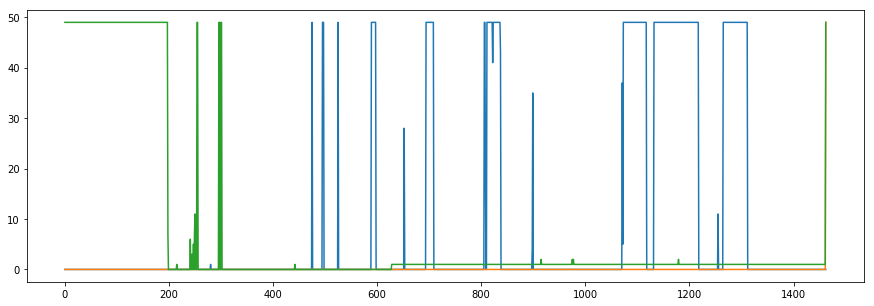

In [58]:
fig = plt.figure(figsize=(15, 5))
plt.plot(np.isnan(nwp_en.ws1000mb.values).sum(1))
plt.plot(np.isnan(nwp_ec.ws100m.values).sum(1))
plt.plot(np.isnan(nwp_nc.ws100m[::2].values).sum(1))

In [59]:
# Convert POSIX to datetime
for nwp in nwps:
    nwp['epoch_s'] = pd.to_datetime(nwp.epoch_s, unit='s')

In [60]:
nwps

[<xarray.Dataset>
 Dimensions:   (epoch_s: 1463, offset_s: 49)
 Coordinates:
   * epoch_s   (epoch_s) datetime64[ns] 2015-01-01 2015-01-01T12:00:00 ...
   * offset_s  (offset_s) int32 0 10800 21600 32400 43200 54000 64800 75600 ...
 Data variables:
     ws100m    (epoch_s, offset_s) float32 5.862752 6.4898725 5.634605 ...
     wd100m    (epoch_s, offset_s) float32 ...
     ws10m     (epoch_s, offset_s) float32 ...
     wd10m     (epoch_s, offset_s) float32 ...
     t2m       (epoch_s, offset_s) float32 ...
     blh       (epoch_s, offset_s) float32 ..., <xarray.Dataset>
 Dimensions:   (epoch_s: 1463, offset_s: 49)
 Coordinates:
   * epoch_s   (epoch_s) datetime64[ns] 2015-01-01 2015-01-01T12:00:00 ...
   * offset_s  (offset_s) int32 0 10800 21600 32400 43200 54000 64800 75600 ...
 Data variables:
     ws1000mb  (epoch_s, offset_s) float32 2.624771 1.5819106 1.6261339 ...
     wd1000mb  (epoch_s, offset_s) float32 ...
     ws925mb   (epoch_s, offset_s) float32 ...
     wd925mb   (epoch_

In [61]:
for nwp in nwps:
    print(nwp.epoch_s.min(), nwp.epoch_s.max())

<xarray.DataArray 'epoch_s' ()>
array('2015-01-01T00:00:00.000000000', dtype='datetime64[ns]') <xarray.DataArray 'epoch_s' ()>
array('2017-01-01T00:00:00.000000000', dtype='datetime64[ns]')
<xarray.DataArray 'epoch_s' ()>
array('2015-01-01T00:00:00.000000000', dtype='datetime64[ns]') <xarray.DataArray 'epoch_s' ()>
array('2017-01-01T00:00:00.000000000', dtype='datetime64[ns]')
<xarray.DataArray 'epoch_s' ()>
array('2015-01-01T00:00:00.000000000', dtype='datetime64[ns]') <xarray.DataArray 'epoch_s' ()>
array('2017-01-01T00:00:00.000000000', dtype='datetime64[ns]')


In [62]:
nwp_ec.offset_s.max() / 60 / 60, (nwp_ec.offset_s[1] - nwp_ec.offset_s[0]) / 60

(<xarray.DataArray 'offset_s' ()>
 array(144.), <xarray.DataArray 'offset_s' ()>
 array(180.))

In [63]:
4*24

96

## Mast data

In [64]:
met = xr.open_dataset(DATA_DIR + 'metobs.nc'); met

<xarray.Dataset>
Dimensions:  (epoch_s: 63072)
Coordinates:
  * epoch_s  (epoch_s) int32 1420070400 1420071300 1420072200 1420073100 ...
Data variables:
    ws_avg   (epoch_s) float32 ...
    wd_avg   (epoch_s) float32 ...
    ws80m    (epoch_s) float32 ...
    ws34m    (epoch_s) float32 ...

In [65]:
# Convert to date time
met['epoch_s'] = pd.to_datetime(met.epoch_s, unit='s')

In [66]:
met.epoch_s.min(), met.epoch_s.max(), met.epoch_s[1] - met.epoch_s[0]

(<xarray.DataArray 'epoch_s' ()>
 array('2015-01-01T00:00:00.000000000', dtype='datetime64[ns]'),
 <xarray.DataArray 'epoch_s' ()>
 array('2016-10-18T23:45:00.000000000', dtype='datetime64[ns]'),
 <xarray.DataArray 'epoch_s' ()>
 array(900000000000, dtype='timedelta64[ns]'))

In [67]:
900000000000 / 1e9 / 60

15.0

## Target wind production data

In [68]:
pwr = xr.open_dataset(DATA_DIR + 'windpark.nc'); pwr

<xarray.Dataset>
Dimensions:   (epoch_s: 94608)
Coordinates:
  * epoch_s   (epoch_s) int32 1420070400 1420071000 1420071600 1420072200 ...
Data variables:
    power     (epoch_s) float32 ...
    rawpower  (epoch_s) float32 ...

In [69]:
# Convert to date time
pwr['epoch_s'] = pwr.epoch_s.values.astype('datetime64[s]')

In [70]:
pwr.epoch_s.min(), pwr.epoch_s.max(), pwr.epoch_s[1] - pwr.epoch_s[0]

(<xarray.DataArray 'epoch_s' ()>
 array('2015-01-01T00:00:00.000000000', dtype='datetime64[ns]'),
 <xarray.DataArray 'epoch_s' ()>
 array('2016-10-18T23:50:00.000000000', dtype='datetime64[ns]'),
 <xarray.DataArray 'epoch_s' ()>
 array(600000000000, dtype='timedelta64[ns]'))

In [71]:
600000000000 / 1e9 / 60

10.0

## EDA

(0, 1)

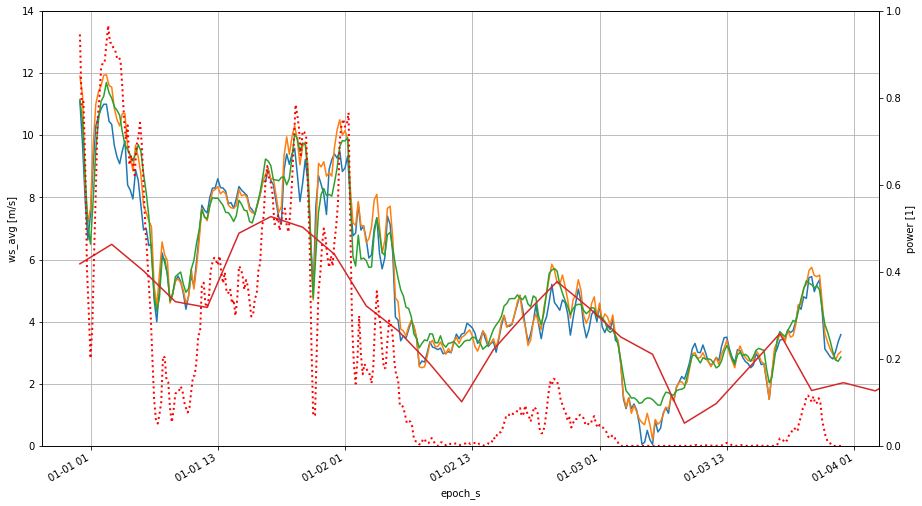

In [72]:
fig = plt.figure(figsize=(15, 8))
met.ws34m.sel(epoch_s=slice('2015-01-01', '2015-01-03')).plot()
met.ws80m.sel(epoch_s=slice('2015-01-01', '2015-01-03')).plot()
met.ws_avg.sel(epoch_s=slice('2015-01-01', '2015-01-03')).plot()
plt.plot(np.datetime64('2015-01-01', 's') + nwp_ec.offset_s, nwp_ec.ws100m.sel(epoch_s='2015-01-01T00'))
plt.grid()
plt.ylim(0, 14)
ax2 = plt.gca().twinx()
pwr.power.sel(epoch_s=slice('2015-01-01', '2015-01-03')).plot(c='r', ls=':', lw=2)
plt.ylim(0, 1)

### Wind farm power curve
The difference between `rawpower` and `power` is not only the removal of obviously wrong power values, but also the correction of the relative farm production in cases where one or several turbines do not contribute due to failure or maintainance.

In [73]:
intersect = np.intersect1d(met.epoch_s, pwr.epoch_s)
print(intersect.shape, pwr.epoch_s.shape)
print(np.isfinite(pwr.rawpower.values).sum(), np.isfinite(pwr.power.values).sum())


(31536,) (94608,)
94608 92568


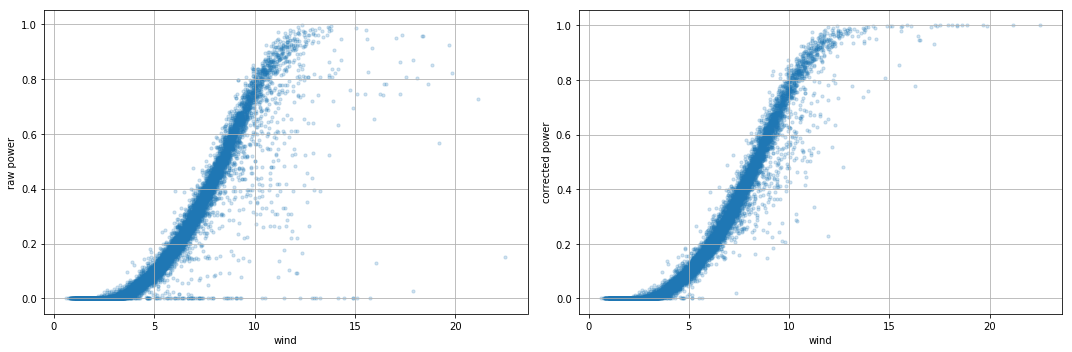

In [74]:
fig = plt.figure(figsize=(15, 5))
plt.subplot(121)
plt.scatter(met.ws_avg.sel(epoch_s=intersect[::2]), pwr.rawpower.sel(epoch_s=intersect[::2]), s=10, alpha=0.2, 
           label='rawpower')
plt.xlabel('wind'); plt.ylabel('raw power'); plt.grid()
plt.subplot(122)
plt.scatter(met.ws_avg.sel(epoch_s=intersect[::2]), pwr.power.sel(epoch_s=intersect[::2]), s=10, alpha=0.2,
           label='power')
plt.xlabel('wind'); plt.ylabel('corrected power'); plt.grid()
plt.tight_layout()

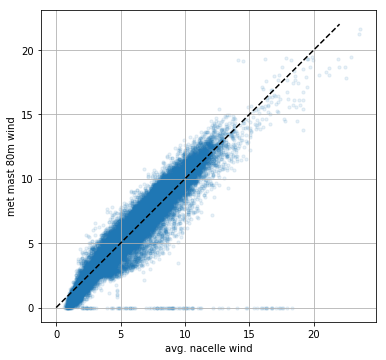

In [75]:
fig = plt.figure(figsize=(6, 6))
plt.scatter(met.ws_avg, met.ws80m, s=10, alpha=0.1)
plt.gca().set_aspect(1.0)
plt.plot([0, 22], [0, 22], 'k--')
plt.xlabel('avg. nacelle wind'); plt.ylabel('met mast 80m wind'); plt.grid()

## Split into datasets and prepare

Total roughly 22 months. For better training results, the validation set should be scattered among the training data, otherwise we focus too much on certain weather situations. Since the correlations are too high between neighboring patterns, split data blockwise.

In [128]:
fc_lead = np.timedelta64(4*24*60*60+1, 's')  # 4 days
pattern_step_h = 3
full_range = np.arange('2015-01-02', np.datetime64('2016-10-18T23:50') - fc_lead, 
                          np.timedelta64(pattern_step_h, 'h'), dtype='datetime64[s]')

# use certain months as test set, to get a good performance estimate for all seasons
test_range = []
for yr, mo in [[2015, 3], [2015, 5], [2015, 7], [2015, 11], [2016, 3], [2016, 8]]:
    test_range.extend(np.arange(f'{yr}-{mo:02d}-01', f'{yr}-%02d-01' % (mo + 1), 
                          np.timedelta64(3, 'h'), dtype='datetime64[s]').tolist())
test_range = np.array(test_range, dtype='datetime64[s]')
exploration_range = np.setdiff1d(full_range, test_range)
print('full:', full_range.size)
print('exp:', exploration_range.size)


full: 5216
exp: 3736


In [129]:
# use (approximately) two days of every 20-day-block as validation set
twenty_days = 20 * 24 // pattern_step_h
two_days = twenty_days//10
print(twenty_days)
val_idx_offs = 100
cropsize = twenty_days * (exploration_range.size // twenty_days)
validation_range = exploration_range[:cropsize].reshape(
    -1, twenty_days)[:, val_idx_offs:val_idx_offs + two_days].flatten()
training_range = np.setdiff1d(exploration_range, validation_range)
print('trn/val/tst: {}/{}/{}'.format(training_range.size, validation_range.size, test_range.size))

160
trn/val/tst: 3368/368/1480


In [130]:
training_range, validation_range

(array(['2015-01-02T00:00:00', '2015-01-02T03:00:00',
        '2015-01-02T06:00:00', ..., '2016-10-14T15:00:00',
        '2016-10-14T18:00:00', '2016-10-14T21:00:00'],
       dtype='datetime64[s]'),
 array(['2015-01-14T12:00:00', '2015-01-14T15:00:00',
        '2015-01-14T18:00:00', '2015-01-14T21:00:00',
        '2015-01-15T00:00:00', '2015-01-15T03:00:00',
        '2015-01-15T06:00:00', '2015-01-15T09:00:00',
        '2015-01-15T12:00:00', '2015-01-15T15:00:00',
        '2015-01-15T18:00:00', '2015-01-15T21:00:00',
        '2015-01-16T00:00:00', '2015-01-16T03:00:00',
        '2015-01-16T06:00:00', '2015-01-16T09:00:00',
        '2015-02-03T12:00:00', '2015-02-03T15:00:00',
        '2015-02-03T18:00:00', '2015-02-03T21:00:00',
        '2015-02-04T00:00:00', '2015-02-04T03:00:00',
        '2015-02-04T06:00:00', '2015-02-04T09:00:00',
        '2015-02-04T12:00:00', '2015-02-04T15:00:00',
        '2015-02-04T18:00:00', '2015-02-04T21:00:00',
        '2015-02-05T00:00:00', '2015-02-05T03

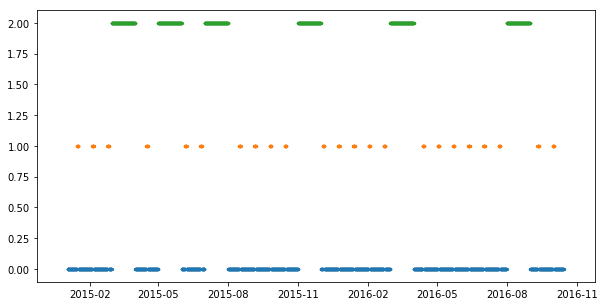

In [131]:
fig = plt.figure(figsize=(10,5))
plt.scatter(training_range, np.zeros(training_range.shape), s=5)
plt.scatter(validation_range, np.ones(validation_range.shape), s=5)
plt.scatter(test_range, np.ones(test_range.shape)*2, s=5);

In [79]:
def split(ds):
    return ds.sel(epoch_s=train_range), ds.sel(epoch_s=validation_range), ds.sel(epoch_s=test_range)

### Option 1: Latest available NWP

In [80]:
nwp_ec

<xarray.Dataset>
Dimensions:   (epoch_s: 1463, offset_s: 49)
Coordinates:
  * epoch_s   (epoch_s) datetime64[ns] 2015-01-01 2015-01-01T12:00:00 ...
  * offset_s  (offset_s) int32 0 10800 21600 32400 43200 54000 64800 75600 ...
Data variables:
    ws100m    (epoch_s, offset_s) float32 5.862752 6.4898725 5.634605 ...
    wd100m    (epoch_s, offset_s) float32 ...
    ws10m     (epoch_s, offset_s) float32 ...
    wd10m     (epoch_s, offset_s) float32 ...
    t2m       (epoch_s, offset_s) float32 ...
    blh       (epoch_s, offset_s) float32 ...

In [81]:
t = full_range[5]; t

numpy.datetime64('2015-01-02T15:00:00')

In [82]:
e = nwp_ec.sel(epoch_s=t, method='ffill'); e

<xarray.Dataset>
Dimensions:   (offset_s: 49)
Coordinates:
    epoch_s   datetime64[ns] 2015-01-02T12:00:00
  * offset_s  (offset_s) int32 0 10800 21600 32400 43200 54000 64800 75600 ...
Data variables:
    ws100m    (offset_s) float32 1.1982974 3.2177408 3.8767595 3.0177443 ...
    wd100m    (offset_s) float32 ...
    ws10m     (offset_s) float32 ...
    wd10m     (offset_s) float32 ...
    t2m       (offset_s) float32 ...
    blh       (offset_s) float32 ...

In [83]:
offset = int(t - e.epoch_s) / 1e9; offset

10800.0

In [84]:
fc_lead_s = fc_lead.astype(int)
fc_buffer_s = 6 * 3600 # use a bit more of the forecast than needed

In [85]:
e = e.sel(offset_s=slice(offset, offset + fc_lead_s + fc_buffer_s))

In [86]:
for v in e.data_vars:
    print(e[v].values)

[3.2177408  3.8767595  3.0177443  3.7520592  3.4736557  2.8936265
 0.47669894 1.0188191  2.6142263  3.3061602  2.8804107  2.5397863
 1.7636383  1.1687864  0.44612274 0.69592863 1.8115056  2.6811018
 2.4919348  2.1451485  1.4637704  0.46662894 1.0340372  2.5155635
 3.708762   3.5387735  2.5905166  1.9959252  1.5648397  1.5317923
 0.9361932  1.5101752  2.7921958  3.8994195  2.7440403 ]
[109.65191    93.45817    34.541077  359.50775   347.96646   345.90237
 324.57196    69.60016    66.858025   58.7036     33.957996  356.82336
 341.2187    343.7704    286.3683     96.82764    79.91599    73.707535
  57.11456   344.63214   332.16666     7.7826166 151.39673   133.12318
 132.57413   107.93736    77.365135   37.791424    8.63618   346.69263
  27.346748   46.58666    77.44297    84.71324    78.75209  ]
[3.0655887  3.5553727  2.9607482  2.9758759  2.2019475  2.0788743
 0.31647304 1.3404034  2.6745107  3.219614   2.7873535  2.0778883
 1.2515666  0.4613566  0.45105767 1.0720751  2.1402678  2.80760

In [132]:
def get_latest_fc(t, nwps, flatten=True):
    a = []
    for nwp in nwps[:1]:
        e = nwp.sel(epoch_s=t, method='ffill')
        offset = int(t - e.epoch_s) / 1e9
        e = e.sel(offset_s=slice(offset, offset + fc_lead_s + fc_buffer_s))
        for v in e.data_vars:
            a.append(e[v].values)
    a = np.array(a)
    return a.reshape(-1) if flatten else a

In [133]:
# validation set
validation_inputs = np.vstack([get_latest_fc(t, nwps, flatten=True) for t in validation_range])
print(validation_inputs.shape)

(368, 210)


In [134]:
fc_resol_s = 10 * 60
time_idxs = np.arange(t, t + fc_lead_s, np.timedelta64(fc_resol_s, 's'), dtype='datetime64[ns]')

In [135]:
pwr.power.sel(epoch_s=time_idxs)

<xarray.DataArray 'power' (epoch_s: 577)>
array([0.019465, 0.015737, 0.025733, ..., 0.018302, 0.022141, 0.012865],
      dtype=float32)
Coordinates:
  * epoch_s  (epoch_s) datetime64[s] 2015-01-02T15:00:00 2015-01-02T15:10:00 ...
Attributes:
    descr:    filtered normalized wind park power output
    units:    1

In [136]:
def get_y(t, da=pwr.power, dt=np.timedelta64(3600, 's')):
    time_idxs = np.arange(t, t + fc_lead_s, dt, dtype='datetime64[ns]')
    return da.sel(epoch_s=time_idxs).values

In [137]:
t

numpy.datetime64('2015-01-02T15:00:00')

In [138]:
print(get_y(t).shape)

(97,)


In [139]:
def generate_patterns_nwp_only(timestamps):
    X, y, yhires = [], [], []
    for t in tqdm(timestamps):
        X.append(get_latest_fc(t, nwps))
        y.append(get_y(t, pwr.power, dt=np.timedelta64(3, 'h')))
        yhires.append(get_y(t, pwr.power, dt=np.timedelta64(30, 'm')))
    return np.array(X), np.array(y), np.array(yhires)

In [140]:
X_train, y_train, yhr_train = generate_patterns_nwp_only(training_range)
X_valid, y_valid, yhr_valid = generate_patterns_nwp_only(validation_range)
X_test, y_test, yhr_test = generate_patterns_nwp_only(test_range)
X_train.shape, y_train.shape, X_valid.shape, y_valid.shape, yhr_valid.shape

((3368, 210), (3368, 33), (368, 210), (368, 33), (368, 193))

In [144]:
X_valid

array([[  2.2630188,   3.2732131,   4.207676 , ..., 319.34073  ,
        569.26794  , 574.12     ],
       [  3.2732131,   4.207676 ,   4.6138773, ..., 569.26794  ,
        574.12     , 496.47928  ],
       [  4.207676 ,   4.6138773,   4.244224 , ..., 574.12     ,
        496.47928  , 200.05518  ],
       ...,
       [  7.504688 ,   7.285331 ,   4.647261 , ..., 368.5109   ,
        369.45734  , 309.7762   ],
       [  7.285331 ,   4.647261 ,   2.6805851, ..., 369.45734  ,
        309.7762   , 285.21368  ],
       [  4.647261 ,   2.6805851,   1.9992894, ..., 309.7762   ,
        285.21368  , 392.2778   ]], dtype=float32)

In [96]:
# normalize input data columnwise
def normalize(X, Xref):
    return (X - Xref.min(0))/(Xref.max(0) - Xref.min(0))
X_valid = normalize(X_valid, X_train)
X_test = normalize(X_test, X_train)
X_train = normalize(X_train, X_train)  

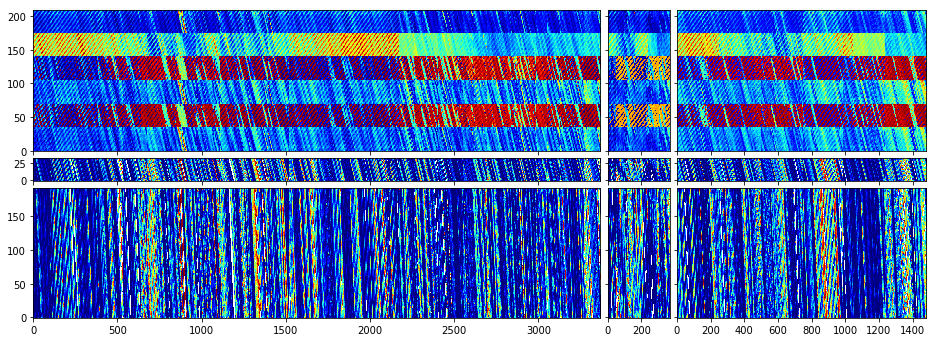

In [97]:
from mpl_toolkits.axes_grid1 import ImageGrid
fig = plt.figure(figsize=(16, 12))
grid = ImageGrid(fig, 111,  # similar to subplot(111)
                 nrows_ncols=(3, 3),
                 axes_pad=0.1, aspect='auto',
                 add_all=True,
                 label_mode="L")
for i, p in enumerate([X_train, X_valid, X_test, y_train, y_valid, y_test, yhr_train, yhr_valid, yhr_test]):
    grid[i].imshow(p.T, origin='lower', interpolation="nearest", cmap='jet', aspect=4.0)

Now check the distribution of targets in the different sets, to make sure we are not biased towards high or low yield in any of them. 

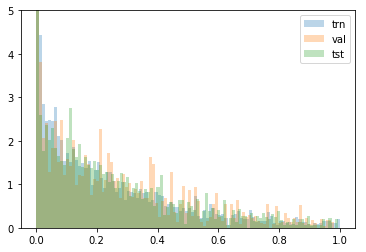

In [98]:
for label, s in zip(['trn', 'val', 'tst'], [y_train, y_valid, y_test]):
    valid = np.isfinite(s.flatten())
    plt.hist(s.flatten()[valid], bins=100, alpha=0.3, density=True, label=label)
plt.ylim(0,5)
plt.legend()

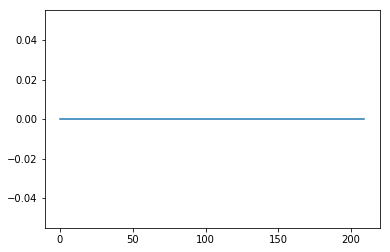

In [99]:
plt.plot(np.isnan(X_train).sum(0))

0.021620600302310517
0.03178524374176548


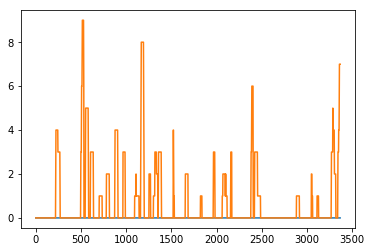

In [110]:
plt.plot(np.isnan(X_train).sum(1))
plt.plot(np.isnan(y_train).sum(1))
print(np.isnan(y_train).sum()/y_train.size)
print(np.isnan(y_valid).sum()/y_valid.size)

In [101]:
# fill the gaps with mean values
# may be a little more accurate if small gaps are interpolated instead
X_train[np.isnan(X_train)] = np.nanmean(X_train)
X_valid[np.isnan(X_valid)] = np.nanmean(X_valid)
y_train_fixed = y_train.copy()
y_train_fixed[np.isnan(y_train_fixed)] = np.nanmean(y_train)
y_valid_fixed = y_valid.copy()
y_valid_fixed[np.isnan(y_valid_fixed)] = np.nanmean(y_train)

In [145]:
keep_idxs = np.isnan(y_train).sum(1) == 0
X_train = X_train[keep_idxs]; y_train_fixed=y_train[keep_idxs]
keep_idxs = np.isnan(y_valid).sum(1) == 0
X_valid = X_valid[keep_idxs]; y_valid_fixed=y_valid[keep_idxs]

In [146]:
X_train.mean(), X_valid.mean()

(163.43132, 164.263)

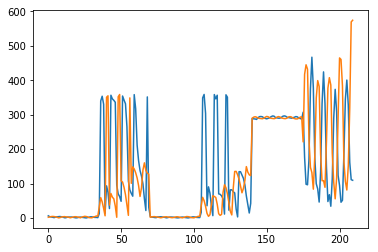

In [119]:
plt.plot(X_train[0])
plt.plot(X_valid[0])

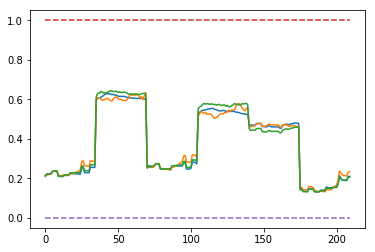

In [102]:
plt.plot(X_train.mean(0))
plt.plot(X_valid.mean(0))
plt.plot(X_test.mean(0))
plt.plot(X_train.max(0), '--')
plt.plot(X_train.min(0), '--')

In [103]:
def rmseplot(models, dset='val', ax=None, xval=None, hires=False):
    if ax is None:
        fig = plt.figure(figsize=(10, 6))
        ax = plt.subplot(111)
    if hasattr(dset, 'append'):
        X, y = dset
        dset = ''
    elif hires:
        X, y = {'trn': [X_train2, yhr_train_fixed], 
                'val': [X_valid2, yhr_valid_fixed], 
                'tst': [X_test2, yhr_test_fixed]}[dset]
    else:
        X, y = {'trn': [X_train, y_train], 'val': [X_valid, y_valid], 'tst': [X_test, y_test]}[dset]

    for i, model in enumerate(models):
        label = str(type(model)).split('.')[-1].replace('Regressor', '')[:-2]
        if xval is None:
            ax.plot(rmse(y, model.predict(X), 0), label=label + f' ({dset})')
        else:
            ax.plot(xval, rmse(y, model.predict(X), 0), label=label + f' ({dset})')
    plt.legend()
    plt.ylim(bottom=0)
    plt.ylabel('RMSE')
    return ax

## Linear regression

In [147]:
#normalize
mean, std = X_train.mean(0), X_train.std(0)
X_train = (X_train - mean) / std
X_valid = (X_valid - mean) / std
X_test = (X_test - mean) / std

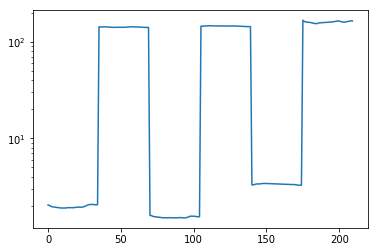

In [148]:
plt.plot(std); plt.yscale('log')

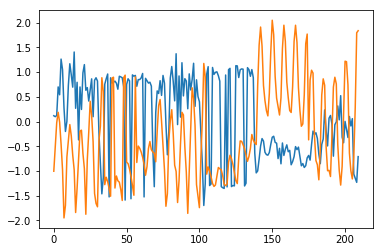

In [149]:
plt.plot(X_train[-1])
plt.plot(X_valid[0])

In [150]:
from sklearn.linear_model import LinearRegression

In [156]:
X_train.shape, y_train_fixed.shape, X_valid.shape

((2507, 210), (2507, 33), (199, 210))

In [151]:
lr = LinearRegression()
print(np.isnan(X_train).sum(), np.isnan(y_train).sum())
lr.fit(X_train, y_train_fixed)

0 2403


LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [152]:
lr.score(X_train, y_train_fixed)

0.5513176563365674

In [153]:
lr.score(X_valid, y_valid_fixed)

0.4438317095920031

In [201]:
def mse(y_true, y_pred, axis=(0,1)): return np.nanmean((y_true - y_pred)**2,axis)
def rmse(y_true, y_pred, axis=(0,1)): return np.sqrt(np.nanmean((y_true - y_pred)**2,axis))

In [204]:
rmse(y_valid_fixed, lr.predict(X_valid))

0.1655196

In [367]:
mse(y_valid, np.ones(y_valid.shape) * np.nanmean(y_train))

0.055667590247985496

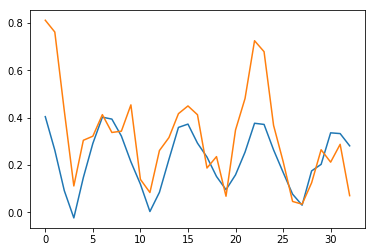

In [368]:
plt.plot(lr.predict(X_valid[180][None])[0])
plt.plot(y_valid[180])

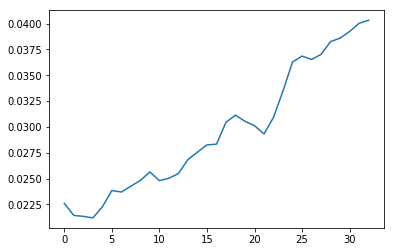

In [369]:
plt.plot(mse(y_valid, lr.predict(X_valid), 0))

## Random forest

In [370]:
from sklearn.ensemble import RandomForestRegressor

In [371]:
rf = RandomForestRegressor(n_estimators=40, n_jobs=-1, min_samples_leaf=10)

In [372]:
%time rf.fit(X_train, y_train_fixed)

CPU times: user 21.6 s, sys: 0 ns, total: 21.6 s
Wall time: 10.9 s


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=10, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=40, n_jobs=-1,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

In [373]:
rf.score(X_train, y_train_fixed), rf.score(X_valid, y_valid_fixed)

(0.5666928766842948, 0.4237093658822535)

In [374]:
preds = rf.predict(X_valid)

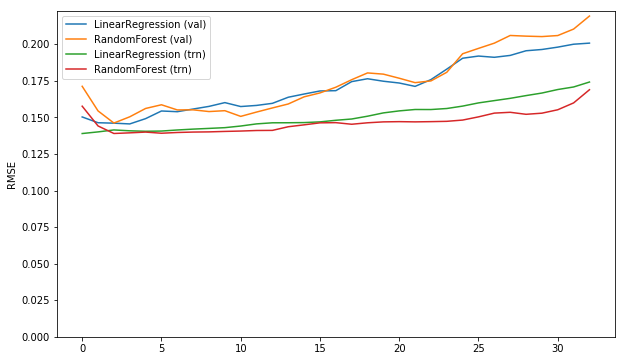

In [375]:
fig = plt.figure(figsize=(10, 6))
ax = plt.subplot(111)
rmseplot([lr, rf], 'val', ax=ax)
rmseplot([lr, rf], 'trn', ax=ax)

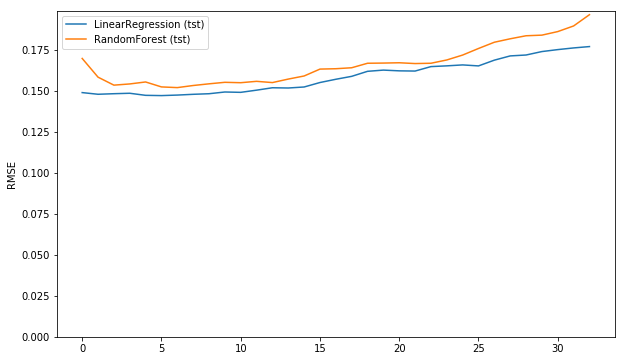

In [376]:
rmseplot([lr, rf], 'tst')

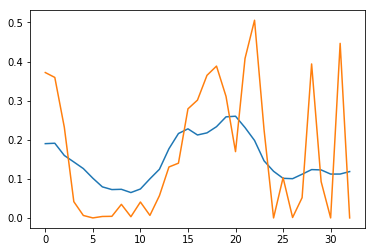

In [377]:
i = 100
plt.plot(preds[i])
plt.plot(y_valid[i])

(0, 1)

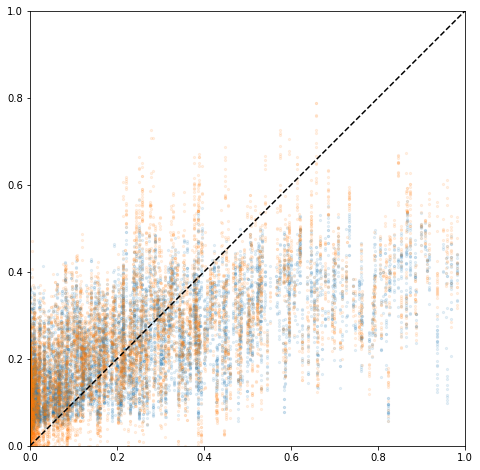

In [378]:
fig = plt.figure(figsize=(8, 8))
plt.scatter(y_valid, rf.predict(X_valid), s=5, alpha=0.1)
plt.scatter(y_valid, lr.predict(X_valid), s=5, alpha=0.1)
plt.gca().set_aspect(1.0)
plt.plot([0,1], [0,1], 'k--')
plt.xlim(0,1) ; plt.ylim(0,1)

## Neural Network w/o early stopping

In [191]:
from sklearn.neural_network import MLPRegressor
nn = MLPRegressor(hidden_layer_sizes=[32, 32], activation='tanh', max_iter=200)

In [196]:
y_valid_fixed.shape

(199, 33)

In [193]:
%time nn.fit(X_train, y_train_fixed)

CPU times: user 13.2 s, sys: 200 ms, total: 13.4 s
Wall time: 1.34 s


MLPRegressor(activation='tanh', alpha=0.0001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=[32, 32], learning_rate='constant',
       learning_rate_init=0.001, max_iter=200, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=None,
       shuffle=True, solver='adam', tol=0.0001, validation_fraction=0.1,
       verbose=False, warm_start=False)

In [194]:
nn.score(X_train, y_train_fixed), nn.score(X_valid, y_valid_fixed)

(0.480541571995504, 0.3964695468711394)

In [178]:
rmseplot([lr, rf, nn], 'val')

NameError: name 'rf' is not defined

## Neural Network with validation set
There is an option `early_stopping` which automatically sets aside a randomly selected validation set. However, we have to do our own validation since our validation data is specially constructed.

In [197]:
def train_nn(X_train, y_train, X_valid, y_valid, hidden_layer_sizes=[32, 32], activation='tanh',
            steps_per_validation=100, tolerance=500, batch_size='auto'):
    # tolerance: epochs to continue, looking for better score
    nn = MLPRegressor(hidden_layer_sizes=hidden_layer_sizes, activation=activation, 
                      max_iter=steps_per_validation, tol=-1, batch_size=batch_size)
    best_score = 0
    best_epoch = 0
    i = 0
    while True:
        i += 1
        nn.fit(X_train, y_train)
        new_score = nn.score(X_valid, y_valid)
        epoch = i * nn.max_iter
        print(f'{epoch:05d}  {new_score:8.5f}  {best_score:8.5f}')
        if new_score > best_score:
            best_score = new_score
            best_model = nn
            best_epoch = epoch
        if epoch - best_epoch > tolerance:
            break
        nn = MLPRegressor(hidden_layer_sizes=hidden_layer_sizes, activation=activation, 
                          max_iter=steps_per_validation, tol=-1, batch_size=batch_size, warm_start=True)
    print('Training finished!')
    return best_model

In [198]:
nn = train_nn(X_train, y_train_fixed, X_valid, y_valid_fixed, hidden_layer_sizes=[32, 32], activation='tanh')

/home/s/S.Rasp/miniconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


00100   0.43666   0.00000
00200   0.41593   0.43666
00300   0.42135   0.43666
00400   0.43474   0.43666
00500   0.42729   0.43666
00600   0.42595   0.43666
00700   0.43612   0.43666
Training finished!


In [199]:
nn.score(X_train, y_train_fixed), nn.score(X_valid, y_valid_fixed)

(0.5710653786222056, 0.4366645925634195)

In [202]:
rmse(nn.predict(X_valid), y_valid_fixed)

0.16658266128974394

This was quite a lot of footwork. Now try the same with Keras.

In [388]:
from keras.models import Sequential
from keras.layers import *
from keras.optimizers import SGD, Adam
nn2 = Sequential([
    Dense(32, input_shape=(X_train.shape[1],), activation='tanh'),
    Dense(32, input_shape=(X_train.shape[1],), activation='tanh'),
    Dense(y_train_fixed.shape[1], activation='linear')
])
print(nn2.summary())
nn2.compile(Adam(5e-4), 'mse')
nn2.fit(X_train, y_train_fixed, batch_size=200, epochs=200, validation_data=(X_valid, y_valid_fixed))
# FIXME: It seems this setup always trains for the given # of epochs. How do I specify a 
# stopping criterion based on the validation set?

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_29 (Dense)             (None, 32)                6752      
_________________________________________________________________
dense_30 (Dense)             (None, 32)                1056      
_________________________________________________________________
dense_31 (Dense)             (None, 33)                1089      
Total params: 8,897
Trainable params: 8,897
Non-trainable params: 0
_________________________________________________________________
None
Train on 3368 samples, validate on 368 samples
Epoch 1/200
3368/3368 [==============================] - 1s 164us/step - loss: 0.2638 - val_loss: 0.2188
Epoch 2/200
3368/3368 [==============================] - 0s 9us/step - loss: 0.1809 - val_loss: 0.1683
Epoch 3/200
3368/3368 [==============================] - 0s 9us/step - loss: 0.1413 - val_loss: 0.1373
Epoch 4/200
3368/3368 [==================

3368/3368 [==============================] - 0s 11us/step - loss: 0.0219 - val_loss: 0.0295
Epoch 151/200
3368/3368 [==============================] - 0s 8us/step - loss: 0.0218 - val_loss: 0.0292
Epoch 152/200
3368/3368 [==============================] - 0s 10us/step - loss: 0.0218 - val_loss: 0.0293
Epoch 153/200
3368/3368 [==============================] - 0s 8us/step - loss: 0.0218 - val_loss: 0.0293
Epoch 154/200
3368/3368 [==============================] - 0s 10us/step - loss: 0.0217 - val_loss: 0.0295
Epoch 155/200
3368/3368 [==============================] - 0s 7us/step - loss: 0.0217 - val_loss: 0.0293
Epoch 156/200
3368/3368 [==============================] - 0s 9us/step - loss: 0.0217 - val_loss: 0.0292
Epoch 157/200
3368/3368 [==============================] - 0s 8us/step - loss: 0.0217 - val_loss: 0.0293
Epoch 158/200
3368/3368 [==============================] - 0s 7us/step - loss: 0.0216 - val_loss: 0.0291
Epoch 159/200
3368/3368 [==============================] - 0s 8us/

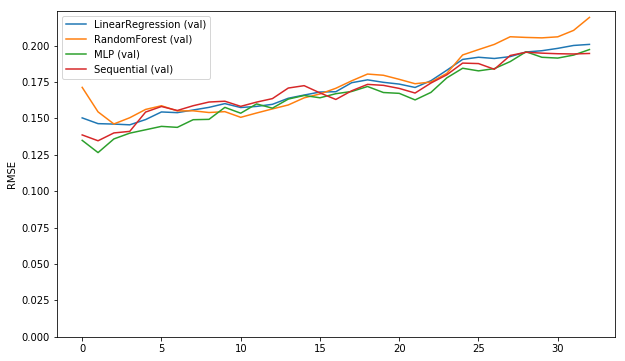

In [389]:
rmseplot([lr, rf, nn, nn2], 'val')

## Add recent observation data for the first few hours

In [390]:
t

numpy.datetime64('2016-08-31T21:00:00')

In [391]:
t_history = np.timedelta64(10, 'h') # how far back to consider obs data
delay = np.timedelta64(6, 'h')     # delay for NWP delivery, i.e. obs are already available for this time range

In [392]:
time_idxs = np.arange(t-t_history, t, np.timedelta64(30, 'm'), dtype='datetime64[ns]')

In [393]:
time_idxs

array(['2016-08-31T11:00:00.000000000', '2016-08-31T11:30:00.000000000',
       '2016-08-31T12:00:00.000000000', '2016-08-31T12:30:00.000000000',
       '2016-08-31T13:00:00.000000000', '2016-08-31T13:30:00.000000000',
       '2016-08-31T14:00:00.000000000', '2016-08-31T14:30:00.000000000',
       '2016-08-31T15:00:00.000000000', '2016-08-31T15:30:00.000000000',
       '2016-08-31T16:00:00.000000000', '2016-08-31T16:30:00.000000000',
       '2016-08-31T17:00:00.000000000', '2016-08-31T17:30:00.000000000',
       '2016-08-31T18:00:00.000000000', '2016-08-31T18:30:00.000000000',
       '2016-08-31T19:00:00.000000000', '2016-08-31T19:30:00.000000000',
       '2016-08-31T20:00:00.000000000', '2016-08-31T20:30:00.000000000'],
      dtype='datetime64[ns]')

In [394]:
met.ws80m

<xarray.DataArray 'ws80m' (epoch_s: 63072)>
array([11.9     , 11.283334,  8.35    , ...,  7.666667,  7.75    ,  7.783333],
      dtype=float32)
Coordinates:
  * epoch_s  (epoch_s) datetime64[ns] 2015-01-01 2015-01-01T00:15:00 ...
Attributes:
    units:    m/s
    descr:    wind speed from met mast at 80 m above surface

In [395]:
def get_met_obs(t, t_back=np.timedelta64(6, 'h'), dt=np.timedelta64(15, 'm'), var='ws_avg', 
                delay=np.timedelta64(0, 'h')):
    time_idxs = np.arange(t + delay - t_back, t + delay, dt, dtype='datetime64[ns]')
    return met[var].sel(epoch_s=time_idxs).values

In [400]:
Xobs_train, Xobs_valid, Xobs_test = [], [], []
for dset, drange in zip([Xobs_train, Xobs_valid, Xobs_test],
                       [training_range, validation_range, test_range]):
    for t in tqdm(drange):
        dset.append(get_met_obs(t, delay=delay))
Xobs_train = np.array(Xobs_train)
Xobs_valid = np.array(Xobs_valid)
Xobs_test = np.array(Xobs_test)


In [404]:
# check in # of NaNs is acceptable
for dset in [Xobs_train, Xobs_valid, Xobs_test]:
    print('{:.3%}'.format(np.isnan(dset).sum()/dset.size))

0.000%
0.000%
0.000%


In [401]:
# Careful: This works only for one type of parameter
Xobs_train[np.isnan(Xobs_train)] = np.nanmean(Xobs_train)
Xobs_valid[np.isnan(Xobs_valid)] = np.nanmean(Xobs_train)
Xobs_test[np.isnan(Xobs_test)] = np.nanmean(Xobs_train)

In [402]:
Xobs_train = np.array(Xobs_train)
Xobs_valid = normalize(np.array(Xobs_valid), Xobs_train)
Xobs_test = normalize(np.array(Xobs_test), Xobs_train)
Xobs_train = normalize(Xobs_train, Xobs_train)

In [403]:
Xobs_train.size

80832

In [406]:
X_train2 = np.hstack([X_train, Xobs_train]); X_train2.shape, X_train.shape

((3368, 234), (3368, 210))

In [407]:
X_test2 = np.hstack([X_test, Xobs_test])
X_valid2 = np.hstack([X_valid, Xobs_valid]); X_valid2.shape, X_valid.shape

((368, 234), (368, 210))

Use only part of the hires targets: before hour 6 (=`delay`) is pointless because this time range lies already in the past at the time when the NWP model runs arrive. Use the next 12 h; after that the effect of current data usually wears off quickly.

In [408]:
# check in # of NaNs in targets is acceptable
for dset in [yhr_train, yhr_valid, yhr_test]:
    print('{:.3%}'.format(np.isnan(dset).sum()/dset.size))

2.038%
2.762%
2.077%


In [409]:
myfc = slice(12, 37)
fc_idx_lores = 3 * np.arange(y_train.shape[1])
fc_idx_hires = 0.5 * np.arange(yhr_train.shape[1])[myfc]
yhr_train_fixed = yhr_train[:, myfc]
yhr_train_fixed[np.isnan(yhr_train_fixed)] = np.nanmean(yhr_train)
yhr_valid_fixed = yhr_valid[:, myfc]
yhr_valid_fixed[np.isnan(yhr_valid_fixed)] = np.nanmean(yhr_train)
yhr_test_fixed = yhr_test[:, myfc]
yhr_test_fixed[np.isnan(yhr_test_fixed)] = np.nanmean(yhr_train)

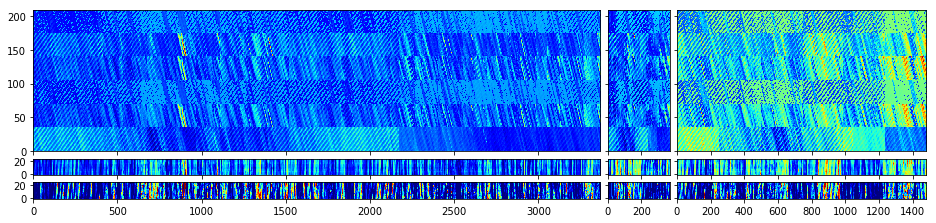

In [410]:
# make a validation plot of the data set configuration
fig = plt.figure(figsize=(16, 12))
grid = ImageGrid(fig, 111,  # similar to subplot(111)
                 nrows_ncols=(3, 3),
                 axes_pad=0.1, aspect='auto',
                 add_all=True,
                 label_mode="L")
for i, p in enumerate([X_train, X_valid, X_test, 
                       Xobs_train, Xobs_valid, Xobs_test, 
                       yhr_train_fixed, yhr_valid_fixed, yhr_test_fixed]):
    grid[i].imshow(p.T, origin='lower', interpolation="nearest", cmap='jet', aspect=4.0)

### train models again

In [411]:
rf2 = RandomForestRegressor(n_estimators=40, n_jobs=-1, min_samples_leaf=10)

In [412]:
%time rf2.fit(X_train2, yhr_train_fixed)

CPU times: user 24.5 s, sys: 0 ns, total: 24.5 s
Wall time: 12.4 s


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=10, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=40, n_jobs=-1,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

In [413]:
rf2.score(X_train2, yhr_train_fixed), rf2.score(X_valid2, yhr_valid_fixed)

(0.7531323204350261, 0.6312671269948555)

In [416]:
nn2 = train_nn(X_train2, yhr_train_fixed, X_valid2, yhr_valid_fixed, hidden_layer_sizes=[35, 35], 
               activation='tanh', batch_size=300, tolerance=1000)

/home/martin/.conda/envs/lmu/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


00100   0.55738   0.00000
00200   0.56485   0.55738
00300   0.57473   0.56485
00400   0.55128   0.57473
00500   0.57773   0.57473
00600   0.57447   0.57773
00700   0.56004   0.57773
00800   0.54793   0.57773
00900   0.58006   0.57773
01000   0.57014   0.58006
01100   0.57053   0.58006
01200   0.55263   0.58006
01300   0.58033   0.58006
01400   0.57457   0.58033
01500   0.57623   0.58033
01600   0.56040   0.58033
01700   0.58196   0.58033
01800   0.57293   0.58196
01900   0.58780   0.58196
02000   0.57190   0.58780
02100   0.55039   0.58780
02200   0.56973   0.58780
02300   0.57425   0.58780
02400   0.59586   0.58780
02500   0.57858   0.59586
02600   0.56185   0.59586
02700   0.57238   0.59586
02800   0.57439   0.59586
02900   0.56548   0.59586
03000   0.58155   0.59586
03100   0.56910   0.59586
03200   0.55456   0.59586
03300   0.56525   0.59586
03400   0.57795   0.59586
03500   0.55186   0.59586
Training finished!


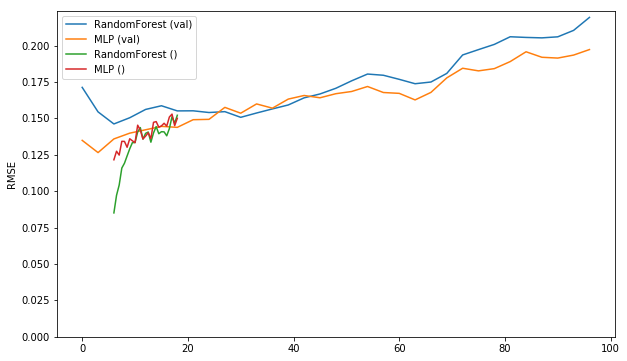

In [417]:
ax = rmseplot([rf, nn], xval=fc_idx_lores, dset='val')
rmseplot([rf2, nn2], xval=fc_idx_hires, dset=[X_valid2, yhr_valid_fixed], ax=ax, hires=True)

In [419]:
print(X_train.max(), Xobs_train.max())
# FIXME what happened to the min/max normalization?

9.652362 1.0


### Weight by fc lead time

In [178]:
y_train.shape

(3368, 33)

In [179]:
weight = np.linspace(2, 1, y_train.shape[1]); weight

array([2.     , 1.96875, 1.9375 , 1.90625, 1.875  , 1.84375, 1.8125 ,
       1.78125, 1.75   , 1.71875, 1.6875 , 1.65625, 1.625  , 1.59375,
       1.5625 , 1.53125, 1.5    , 1.46875, 1.4375 , 1.40625, 1.375  ,
       1.34375, 1.3125 , 1.28125, 1.25   , 1.21875, 1.1875 , 1.15625,
       1.125  , 1.09375, 1.0625 , 1.03125, 1.     ])

In [180]:
rf3 = RandomForestRegressor(n_estimators=40, n_jobs=-1, min_samples_leaf=10)

In [181]:
%time rf3.fit(X_train2, y_train_fixed * weight)

CPU times: user 24.3 s, sys: 0 ns, total: 24.3 s
Wall time: 12.2 s


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=10, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=40, n_jobs=-1,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

In [182]:
rf3.score(X_train2, y_train_fixed*weight), rf3.score(X_valid2, y_valid_fixed*weight)

(0.5991946392980076, 0.4680293118340878)

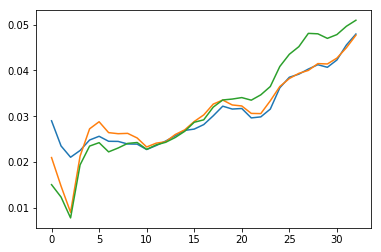

In [183]:
plt.plot(mse(y_valid, rf.predict(X_valid), 0))
plt.plot(mse(y_valid, rf2.predict(X_valid2), 0))
plt.plot(mse(y_valid, rf3.predict(X_valid2)/weight, 0))

### Separate models

In [412]:
rf_early = RandomForestRegressor(n_estimators=40, n_jobs=-1, min_samples_leaf=10)

In [413]:
y_train.shape

(3376, 97)

In [414]:
%time rf_early.fit(X_train2, y_train_fixed[:, :25])

CPU times: user 23.8 s, sys: 11.5 ms, total: 23.8 s
Wall time: 3.13 s


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=10, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=40, n_jobs=-1,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

In [415]:
rf_late = RandomForestRegressor(n_estimators=40, n_jobs=-1, min_samples_leaf=10)

In [416]:
%time rf_late.fit(X_train2, y_train_fixed[:, 25:])

CPU times: user 39.7 s, sys: 28.8 ms, total: 39.7 s
Wall time: 5.38 s


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=10, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=40, n_jobs=-1,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

In [417]:
preds_concat = np.hstack([rf_early.predict(X_valid2), rf_late.predict(X_valid2)]); preds_concat.shape

(368, 97)

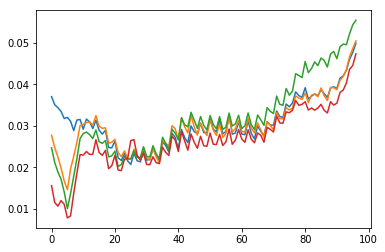

In [418]:
plt.plot(mse(y_valid, rf.predict(X_valid), 0))
plt.plot(mse(y_valid, rf2.predict(X_valid2), 0))
plt.plot(mse(y_valid, rf3.predict(X_valid2)/weight, 0))
plt.plot(mse(y_valid, preds_concat, 0))

### 10 minute interval forecasts

In [206]:
y_train_10m = []
every_3_hours_train = every_3_hours[(every_3_hours >= np.datetime64(train_range.start)) & 
                                    (every_3_hours <= np.datetime64(train_range.stop))]
for t in tqdm(every_3_hours_train):
    y_train_10m.append(get_y(t, dt=np.timedelta64(10, 'm')))

In [207]:
y_valid_10m = []
for t in tqdm(every_3_hours_valid):
    y_valid_10m.append(get_y(t, dt=np.timedelta64(10, 'm')))

In [208]:
y_train_10m = np.array(y_train_10m)
y_valid_10m = np.array(y_valid_10m)
y_train_10m.shape, y_valid_10m.shape, y_train.shape

((2909, 577), (961, 577), (2909, 33))

In [209]:
rf_10m = RandomForestRegressor(n_estimators=40, n_jobs=-1, min_samples_leaf=10)

In [210]:
%time rf_10m.fit(X_train2, y_train_10m)

CPU times: user 12min 13s, sys: 172 ms, total: 12min 13s
Wall time: 39.2 s


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=10, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=40, n_jobs=-1,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

In [213]:
rf2.score(X_train2, y_train), rf2.score(X_valid2, y_valid)

(0.5954800844911506, 0.4425051260286215)

In [212]:
rf_10m.score(X_train2, y_train_10m), rf_10m.score(X_valid2, y_valid_10m)

(0.5945406041224824, 0.4396679652228934)

In [214]:
preds = rf_10m.predict(X_valid2)

In [215]:
preds.shape, y_valid_10m.shape

((961, 577), (961, 577))

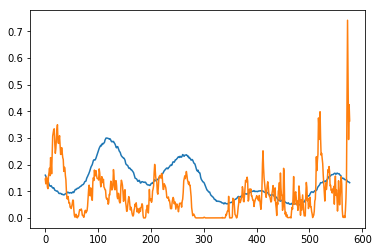

In [216]:
i = 0
plt.plot(preds[i])
plt.plot(y_valid_10m[i])

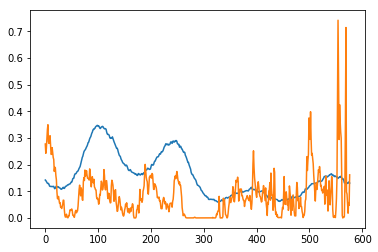

In [218]:
i = 1
plt.plot(preds[i])
plt.plot(y_valid_10m[i])